In [67]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Define image size and paths
img_height, img_width = 150, 150
batch_size = 32
base_dir = "/Users/mansivarshney/Projects/CNNs/chest_xray"  # update path if needed

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


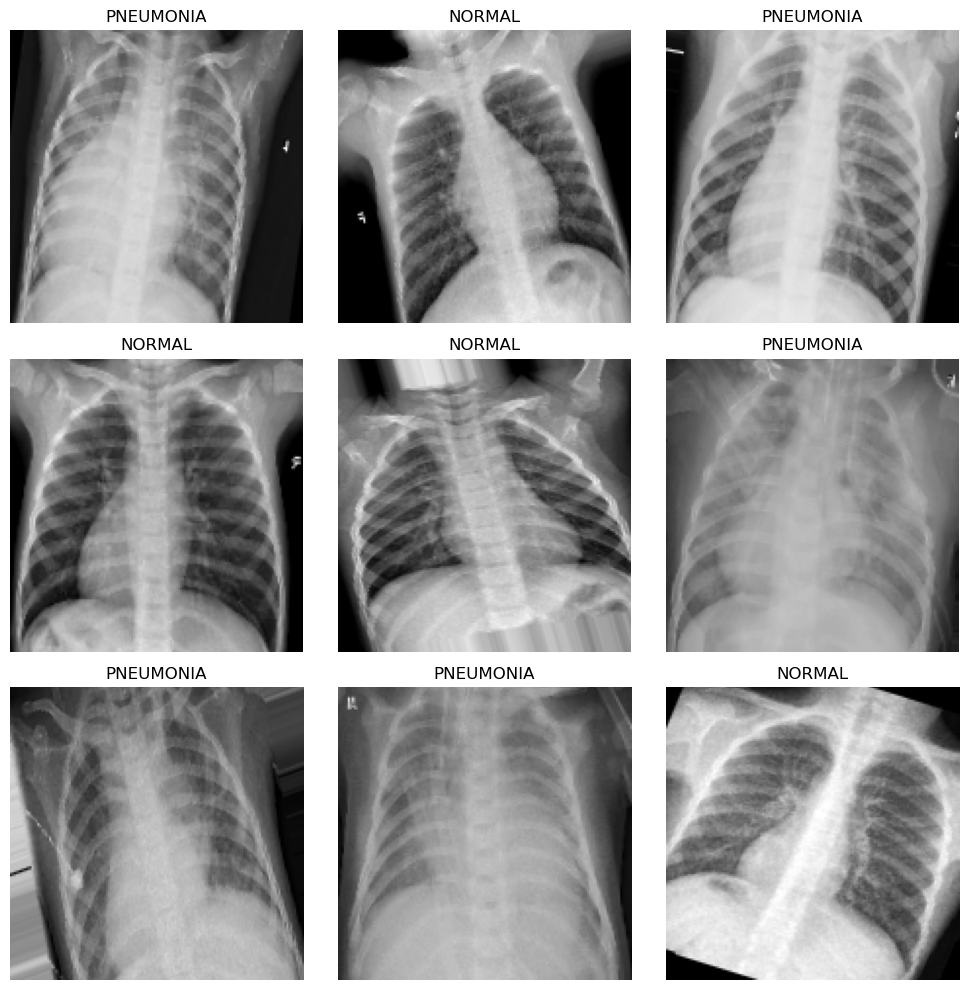

In [69]:
# Visualize a few training images
class_names = ['NORMAL', 'PNEUMONIA']
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(class_names[int(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

### Define the CNN Model

In [72]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

### Compile the Model

In [75]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### Train the Model

In [78]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 260ms/step - accuracy: 0.7797 - loss: 0.5009 - val_accuracy: 0.8125 - val_loss: 0.5344
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.8738 - loss: 0.2927 - val_accuracy: 0.6875 - val_loss: 0.6981
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 273ms/step - accuracy: 0.8993 - loss: 0.2531 - val_accuracy: 0.6875 - val_loss: 0.6690
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 271ms/step - accuracy: 0.9122 - loss: 0.2319 - val_accuracy: 0.6875 - val_loss: 0.8731
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 278ms/step - accuracy: 0.9201 - loss: 0.2068 - val_accuracy: 0.6875 - val_loss: 1.1232
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 289ms/step - accuracy: 0.9252 - loss: 0.1876 - val_accuracy: 0.5625 - val_loss: 0.8734
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step - accuracy: 0.9339 - loss: 0.1848 - val_accuracy: 0.6250 - val_loss: 0.6256
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step - accuracy: 0.9365 - loss: 0

### Evaluate on Test Data

In [80]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9167 - loss: 0.3312
Test Accuracy: 91.67%


### Plot Accuracy & Loss

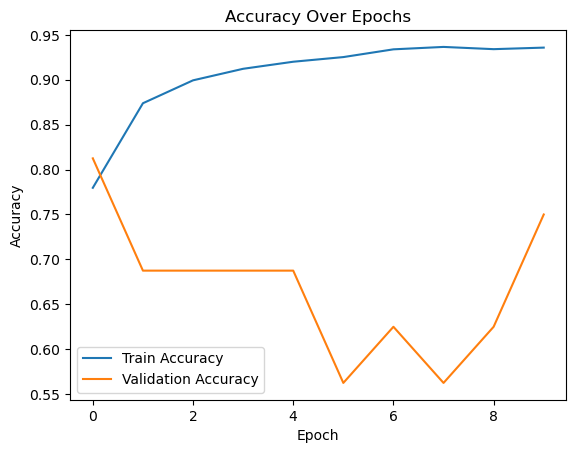

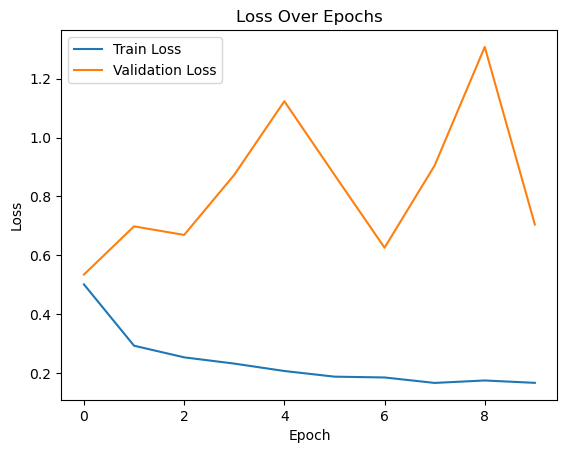

In [82]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Save the Trained Model

In [84]:
# Save the model
model.save("chest_xray_cnn_model.h5")
print("Model saved as chest_xray_cnn_model.h5")

Model saved as chest_xray_cnn_model.h5


### Predict on New Chest X-ray Image

In [86]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Load saved model
model = load_model("chest_xray_cnn_model.h5")

# Load and preprocess new image
img_path = "new_xray.jpeg"  # update path if needed
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

# Make prediction
prediction = model.predict(img_array)

pred_value = prediction[0][0] if prediction.ndim == 2 else prediction[0]

# Interpret result
if prediction[0][0] > 0.5:
    label = "PNEUMONIA"
    confidence = pred_value
    print(f"Prediction: Pneumonia ({prediction[0][0]:.4f})")
else:
    label = "NORMAL"
    confidence = 1 - pred_value
    print(f"Prediction: Normal ({1 - prediction[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction: Normal (0.9898)


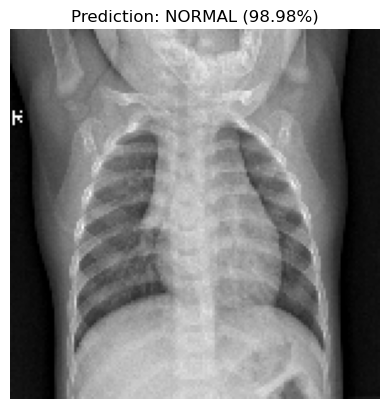

In [87]:
# Show result
plt.imshow(img)
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()